In [1]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000



TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'




# Backtest the results



# Add additional technical indicators TODO add indicators
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']


# FEATURES = ["close", "high", "low", "volume"].extend(INDICATORS)

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
TEST_TICKER = [
   "AXP",
    "AMGN",
    "AAPL",
    "BA",
]


df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRAIN_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()

from finrl.meta.preprocessor.preprocessors import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (11836, 8)
Successfully added technical indicators
Successfully added turbulence index


In [2]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.31332941 0.43188074 0.33824661 ... 0.06618093 0.0643527  0.05127709]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.   0.25 0.5 ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-04-01,0.026929,0.028049,0.027619,0.024498,0.313329,AAPL,0.50,0.000000,1.000000,0.168245,1.000000,0.000000
1,2009-04-01,0.187558,0.184662,0.182332,0.149647,0.216841,AMGN,0.50,0.000000,1.000000,0.137498,1.000000,0.000000
2,2009-04-01,0.097793,0.105987,0.096092,0.089370,0.306650,AXP,0.50,0.000000,1.000000,0.156156,1.000000,0.000000
3,2009-04-01,0.077397,0.079819,0.077716,0.062400,0.089997,BA,0.50,0.000000,1.000000,0.150477,1.000000,0.000000
4,2009-04-02,0.028494,0.029528,0.029185,0.025404,0.431881,AAPL,0.75,0.000369,1.000000,0.168245,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11831,2020-12-29,0.489451,0.497029,0.489334,0.502556,0.141395,BA,0.25,0.071507,0.562819,-0.049002,0.108247,0.012913
11832,2020-12-30,0.982108,0.979826,0.993003,0.978272,0.051277,AAPL,0.50,0.529816,0.611788,0.350612,0.388458,0.003595
11833,2020-12-30,0.876576,0.864362,0.877129,0.882334,0.037800,AMGN,0.50,-0.101863,0.483518,0.061310,0.031932,0.003595
11834,2020-12-30,0.866872,0.868385,0.867984,0.884702,0.021632,AXP,0.50,0.068323,0.566845,0.016703,0.027590,0.003595


# Portfolio Optimization Algorithm

In [3]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

In [4]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

C:\Users\bencj\AppData\Local\Temp\ipykernel_20644\3962532677.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


<All keys matched successfully>

In [5]:
EIIE_results = {
    "train": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
EIIE_results["train"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["train"]["value"], columns=['opt_net_worth'])
df_date = pd.DataFrame(EIIE_results["train"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 11077054.0
Final accumulative portfolio value: 11.077054
Maximum DrawDown: -0.44583149080826756
Sharpe ratio: 1.0367809011150284


In [6]:
print(df_opt)

      opt_net_worth       Date
0      1.000000e+06 2009-05-06
1      9.760586e+05 2009-05-07
2      1.012637e+06 2009-05-08
3      9.900429e+05 2009-05-11
4      9.726858e+05 2009-05-12
...             ...        ...
2930   1.094628e+07 2020-12-23
2931   1.094490e+07 2020-12-24
2932   1.106173e+07 2020-12-28
2933   1.106149e+07 2020-12-29
2934   1.107705e+07 2020-12-30

[2935 rows x 2 columns]


In [7]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2009-05-06 00:00:00
2020-12-30 00:00:00


# PPO On portfolio Opt

In [8]:


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up, TODO fix this for real dates
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

print(opt_start_date)

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

train = data_split(portfolio_norm_df, new_opt_start_str,opt_end)

environment_ppo = PortfolioOptimizationEnv(
    train,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low", 'macd',
            'rsi_30',
            'cci_30',
            'dx_30'], # Lets use the other indicators
    normalize_df=None,
    reward_scaling=1e-4,
)

2009-05-06 00:00:00


In [9]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models with features


trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + "/agent_opt_ppo_features_4_1117_2020") 

In [10]:
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent


PPO_results = {
    "train": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo)
PPO_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["train"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["train"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["train"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)


print(df_opt.loc[0,'Date'])
print(df_ppo_opt.loc[0, 'Date'])

# assert the dates line up
assert df_opt.loc[0,'Date'] == df_ppo_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_ppo_opt.loc[len(df_ppo_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\env_portfolio_optimization\env_portfolio_optimization.py:308: RuntimeWarning: invalid value encountered in divide
  weights = actions / action_sum
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\env_portfolio_optimization\env_portfolio_optimization.py:308: RuntimeWarning: invalid value encountered in divide
  weights = actions / action_sum
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\env_portfolio_optimization\env_portfolio_optimization.py:308: RuntimeWarning: invalid value encountered in divide
  weights 

Initial portfolio value:1000000
Final portfolio value: 4143109.25
Final accumulative portfolio value: 4.14310925
Maximum DrawDown: -0.4353274752131332
Sharpe ratio: 0.6820294060980857
hit end!
      ppo_opt_net_worth       Date
0          1.000000e+06 2009-05-06
1          9.855231e+05 2009-05-07
2          1.014993e+06 2009-05-08
3          1.008778e+06 2009-05-11
4          1.004735e+06 2009-05-12
...                 ...        ...
2930       4.140946e+06 2020-12-23
2931       4.121635e+06 2020-12-24
2932       4.126488e+06 2020-12-28
2933       4.124687e+06 2020-12-29
2934       4.143109e+06 2020-12-30

[2935 rows x 2 columns]
2009-05-06 00:00:00
2009-05-06 00:00:00


In [11]:
df_ppo_opt.loc[0, 'Date']

Timestamp('2009-05-06 00:00:00')

In [12]:
df_opt.loc[0,'Date']

Timestamp('2009-05-06 00:00:00')

# Porfolio Baselines

In [13]:
# CRP 

CRP_results = {
    "train": {},
}

environment_ppo.reset()
agent_crp = DRLStableAgent(env = environment_ppo)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_ppo)
CRP_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
CRP_results["train"]["date"] = environment_ppo._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["train"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["train"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 11077612.0
Final accumulative portfolio value: 11.077612
Maximum DrawDown: -0.44583312857479607
Sharpe ratio: 1.0367901255757175
hit end!
      crp_opt_net_worth       Date
0          1.000000e+06 2009-05-06
1          9.760556e+05 2009-05-07
2          1.012638e+06 2009-05-08
3          9.900412e+05 2009-05-11
4          9.726822e+05 2009-05-12
...                 ...        ...
2930       1.094684e+07 2020-12-23
2931       1.094545e+07 2020-12-24
2932       1.106229e+07 2020-12-28
2933       1.106205e+07 2020-12-29
2934       1.107761e+07 2020-12-30

[2935 rows x 2 columns]


In [14]:
# BAH

BAH_results = {
    "train": {},
}

environment_ppo.reset()
agent_bah = DRLStableAgent(env = environment_ppo)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_ppo)
BAH_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
BAH_results["train"]["date"] = environment_ppo._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["train"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["train"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 12603424.0
Final accumulative portfolio value: 12.603424
Maximum DrawDown: -0.41118948277957246
Sharpe ratio: 1.0896060004084052
hit end!
      bah_opt_net_worth       Date
0          1.000000e+06 2009-05-06
1          9.760556e+05 2009-05-07
2          1.012324e+06 2009-05-08
3          9.888025e+05 2009-05-11
4          9.717184e+05 2009-05-12
...                 ...        ...
2930       1.240153e+07 2020-12-23
2931       1.244895e+07 2020-12-24
2932       1.274605e+07 2020-12-28
2933       1.265455e+07 2020-12-29
2934       1.260342e+07 2020-12-30

[2935 rows x 2 columns]


In [15]:
# OLMAR

OLMAR_results = {
    "train": {},
}

OLMAR_kwargs = {
    "eps": 60,
    "window": 100
}



environment_ppo.reset()
agent_olmar = DRLStableAgent(env = environment_ppo)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=OLMAR_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_ppo)
OLMAR_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
OLMAR_results["train"]["date"] = environment_ppo._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["train"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["train"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 4384397.0
Final accumulative portfolio value: 4.384397
Maximum DrawDown: -0.7445601505581452
Sharpe ratio: 0.5395721147199791
hit end!
      olmar_opt_net_worth       Date
0            1.000000e+06 2009-05-06
1            9.760556e+05 2009-05-07
2            9.770828e+05 2009-05-08
3            8.940978e+05 2009-05-11
4            8.799392e+05 2009-05-12
...                   ...        ...
2930         4.302758e+06 2020-12-23
2931         4.302564e+06 2020-12-24
2932         4.316461e+06 2020-12-28
2933         4.378608e+06 2020-12-29
2934         4.384397e+06 2020-12-30

[2935 rows x 2 columns]


In [16]:
# RMR 

RMR_results = {
    "train": {},
}

RMR_model_kwargs = {
    "eps": 60,
    "window": 100
}

environment_ppo.reset()
agent_rmr = DRLStableAgent(env = environment_ppo)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=RMR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_ppo)
RMR_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
RMR_results["train"]["date"] = environment_ppo._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["train"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["train"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 25026170.0
Final accumulative portfolio value: 25.02617
Maximum DrawDown: -0.43797153171796266
Sharpe ratio: 1.1116308081699071
hit end!
      rmr_opt_net_worth       Date
0          1.000000e+06 2009-05-06
1          9.760556e+05 2009-05-07
2          9.770828e+05 2009-05-08
3          8.940978e+05 2009-05-11
4          8.799392e+05 2009-05-12
...                 ...        ...
2930       2.450963e+07 2020-12-23
2931       2.469865e+07 2020-12-24
2932       2.558202e+07 2020-12-28
2933       2.524140e+07 2020-12-29
2934       2.502617e+07 2020-12-30

[2935 rows x 2 columns]


In [17]:
# BNN

BNN_results = {
    "20212024": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_ppo.reset()
agent_bnn = DRLStableAgent(env = environment_ppo)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_ppo)
BNN_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
BNN_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["20212024"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["20212024"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 18717096.0
Final accumulative portfolio value: 18.717096
Maximum DrawDown: -0.4379715596092153
Sharpe ratio: 1.0245925340193998
hit end!
      bnn_opt_net_worth       Date
0             1000000.0 2009-05-06
1             1000000.0 2009-05-07
2             1000000.0 2009-05-08
3             1000000.0 2009-05-11
4             1000000.0 2009-05-12
...                 ...        ...
2930         18330774.0 2020-12-23
2931         18472144.0 2020-12-24
2932         19132818.0 2020-12-28
2933         18878064.0 2020-12-29
2934         18717096.0 2020-12-30

[2935 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [18]:
# bcrp

BCRP_results = {
    "train": {},
}

environment_ppo.reset()
agent_bcrp= DRLStableAgent(env = environment_ppo)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_ppo)
BCRP_results["train"]["value"] = environment_ppo._terminal_asset_memory["final"]
BCRP_results["train"]["date"] = environment_ppo._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["train"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["train"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 32756878.0
Final accumulative portfolio value: 32.756878
Maximum DrawDown: -0.4379715905951912
Sharpe ratio: 1.2026666008584097
hit end!
      bcrp_opt_net_worth       Date
0           1.000000e+06 2009-05-06
1           9.740377e+05 2009-05-07
2           9.750193e+05 2009-05-08
3           9.778870e+05 2009-05-11
4           9.390188e+05 2009-05-12
...                  ...        ...
2930        3.208077e+07 2020-12-23
2931        3.232818e+07 2020-12-24
2932        3.348443e+07 2020-12-28
2933        3.303859e+07 2020-12-29
2934        3.275688e+07 2020-12-30

[2935 rows x 2 columns]


# Stock environment optimization algorithm

In [19]:
from finrl.meta.preprocessor.preprocessors import data_split

# Make sure we only test on the same data as the portfolio optimization algorithm
# test = data_split(test, opt_start,opt_end)


In [20]:
# from stable_baselines3 import PPO, TD3, A2C
# from finrl.config import TRAINED_MODEL_DIR


# # Load the trained models
# trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") 

# trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") 

# trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") 

In [21]:
# Test out of sample performance

# stock_dimension = len(test.tic.unique())
# state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
# print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

In [22]:
# buy_cost_list = sell_cost_list = [COMMISSION_FEE_PERCENT] * stock_dimension
# num_stock_shares = [0] * stock_dimension

# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": INITIAL_CASH,
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list,
#     "sell_cost_pct": sell_cost_list,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4
# }

In [23]:
# e_trade_gym_ppo = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_ppo, df_actions_ppo = StockDRLAgent.DRL_prediction(
#     model=trained_ppo, 
#     environment = e_trade_gym_ppo,
#     deterministic=True)

In [24]:
# df_account_value_ppo.rename(columns={'date': 'Date', 'account_value' : "ppo_value"}, inplace=True)
# df_account_value_ppo

In [25]:
# e_trade_gym_td3 = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_td3, df_actions_td3 = StockDRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym_td3)

In [26]:
# df_account_value_td3.rename(columns={'date': 'Date', 'account_value' : "td3_value"}, inplace=True)
# df_account_value_td3

In [27]:

# e_trade_gym_a2c = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_a2c, df_actions_a2c = StockDRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym_a2c)

# df_account_value_a2c.rename(columns={'date': 'Date', 'account_value' : "a2c_value"}, inplace=True)
# df_account_value_a2c

In [28]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (2934, 8)
Annual return          0.115329
Cumulative returns     2.563754
Annual volatility      0.173645
Sharpe ratio           0.716150
Calmar ratio           0.310977
Stability              0.965052
Max drawdown          -0.370862
Omega ratio            1.152667
Sortino ratio          0.999476
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.953392
Daily value at risk   -0.021384
dtype: float64
df_dji:             date           dji
0    2009-05-06  1.000000e+06
1    2009-05-07  9.879667e+05
2    2009-05-08  1.007327e+06
3    2009-05-11  9.890146e+05
4    2009-05-12  9.949285e+05
...         ...           ...
2930 2020-12-23  3.539572e+06
2931 2020-12-24  3.547800e+06
2932 2020-12-28  3.571777e+06
2933 2020-12-29  3.563754e+06
2934 2020-12-30           NaN

[2935 rows x 2 columns]
df_dji:                       dji
date                    
2009-05-06  1.000000e+06
2009-05-07  9.879667e+05
2009-05-08  1.007327e+06
2009-05-11

# Compare all results

In [29]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')
# olmar = pd.read_csv('OLMAR_net_worth.csv')



# merged_df = olmar
# merged_df = pd.merge(merged_df, olmar, on='Date')

# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO opt algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')


print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2009-05-06  1.000000e+06
2009-05-07  9.879667e+05
2009-05-08  1.007327e+06
2009-05-11  9.890146e+05
2009-05-12  9.949285e+05
...                  ...
2020-12-23  3.539572e+06
2020-12-24  3.547800e+06
2020-12-28  3.571777e+06
2020-12-29  3.563754e+06
2020-12-30           NaN

[2935 rows x 1 columns]
      crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0          1.000000e+06 2009-05-06        1.000000e+06       1.000000e+06   
1          9.760556e+05 2009-05-07        9.740377e+05       9.760556e+05   
2          1.012638e+06 2009-05-08        9.750193e+05       1.012324e+06   
3          9.900412e+05 2009-05-11        9.778870e+05       9.888025e+05   
4          9.726822e+05 2009-05-12        9.390188e+05       9.717184e+05   
...                 ...        ...                 ...                ...   
2930       1.094684e+07 2020-12-23        3.208077e+07       1.240153e+07   
2931       1.094545e+07 2020-12-24

# Baseline CRP in the environment

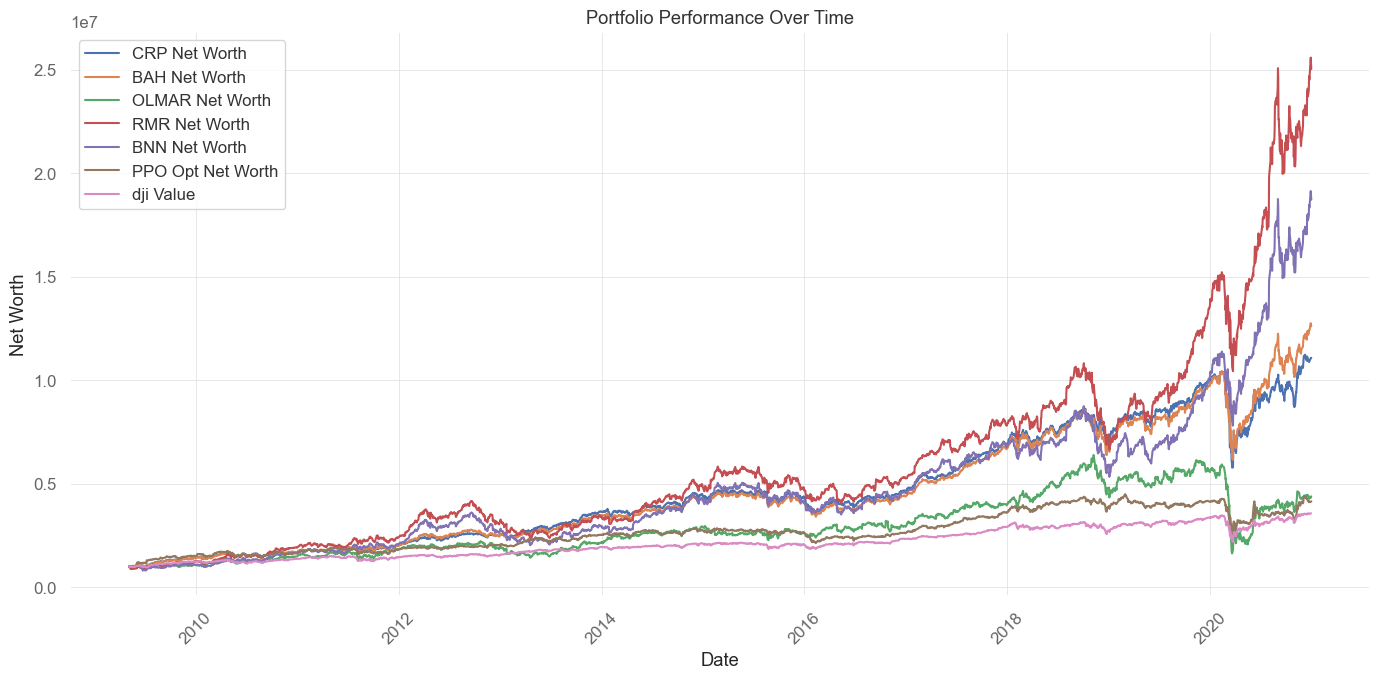

In [30]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

# Plot the DataFrame
plt.figure(figsize=(14, 7))
#plt.plot(merged_df['Date'], merged_df['BCRP_net_worth'], label='BCRP Net Worth')
# plt.plot(merged_df['Date'], merged_df['bcrp_opt_net_worth'], label='BCRP Net Worth')
# plt.plot(merged_df['Date'], merged_df['CRP_net_worth'], label='CRP Net Worth')# CRP and Opt net worth are basically on the same line
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth')
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth')
plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth')
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth')
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth')

# plt.plot(merged_df['Date'], merged_df['OLMAR_net_worth'], label='OLMAR Net Worth - old')
# plt.plot(merged_df['Date'], merged_df['opt_net_worth'], label='Opt Net Worth')
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO Opt Net Worth')
# plt.plot(merged_df['Date'], merged_df['ppo_value'], label='PPO Value')
# plt.plot(merged_df['Date'], merged_df['td3_value'], label='TD3 Value')
# plt.plot(merged_df['Date'], merged_df['a2c_value'], label='A2C Value')
plt.plot(merged_df['Date'], merged_df['dji'], label='dji Value')
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# Final returns

import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
   'PPO': merged_df['ppo_opt_net_worth'].iloc[-1]
}

pprint.pprint(final_returns)

{'BAH': 12603424.0,
 'BCRP OPT': 32756878.0,
 'BNN': 18717096.0,
 'CRP': 11077612.0,
 'OLMAR': 4384397.0,
 'PPO': 4143109.25,
 'RMR': 25026170.0}


In [32]:
import numpy as np

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['opt_daily_return'] = merged_df['opt_net_worth'].pct_change()
merged_df['ppo_opt_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()
# merged_df['ppo_daily_return'] = merged_df['ppo_value'].pct_change()
# merged_df['td3_daily_return'] = merged_df['td3_value'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP OPT': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP OPT': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'BAH OPT': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO Opt': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return'], risk_free_rate),
    # 'PPO': calculate_sharpe_ratio(merged_df['ppo_daily_return'], risk_free_rate),
    # 'TD3': calculate_sharpe_ratio(merged_df['td3_daily_return'], risk_free_rate)
}

pprint.pprint(sharpe_ratios)

{'BAH OPT': 0.9999398898221792,
 'BCRP OPT': 1.1320691139645607,
 'BNN': 0.9546873980161159,
 'CRP OPT': 0.9474227432957113,
 'OLMAR': 0.482040843121582,
 'PPO Opt': 0.5876396866621957,
 'RMR': 1.0417750710677025}


In [33]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP Opt': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP Opt': max_drawdown(merged_df['crp_opt_net_worth']),
    'BAH Opt': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR Opt': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR Opt': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN Opt': max_drawdown(merged_df['bnn_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO Opt': max_drawdown(merged_df['ppo_opt_net_worth']),
    # 'PPO': max_drawdown(merged_df['ppo_value']),
    # 'TD3': max_drawdown(merged_df['td3_value'])
}

pprint.pprint(max_drawdowns)


{'BAH Opt': -0.41118948277957246,
 'BCRP Opt': -0.4379715905951912,
 'BNN Opt': -0.4379715596092153,
 'CRP Opt': -0.44583312857479607,
 'OLMAR Opt': -0.7445601505581452,
 'PPO Opt': -0.4353274752131332,
 'RMR Opt': -0.43797153171796266}


In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['ppo_opt_daily_return', 'CRP_opt_daily_return', 'BCRP_opt_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq       df         F    PR(>F)
Portfolio  0.000886      3.0  1.329105  0.262892
Residual   2.607222  11732.0       NaN       NaN
